In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

<AxesSubplot:xlabel='Date'>

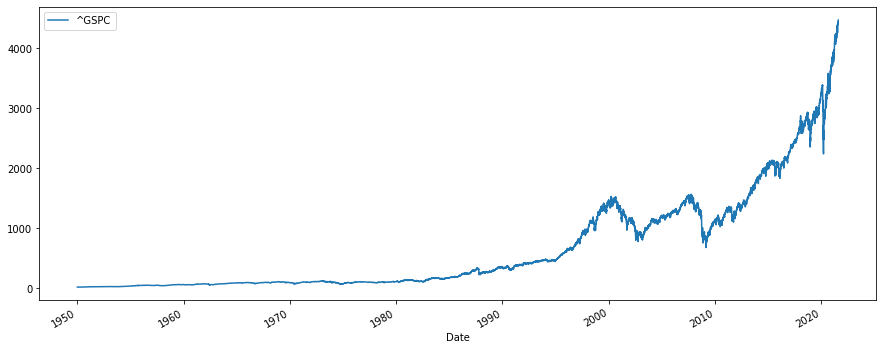

In [2]:
# retrieve S&P 500 daily adjusted close
startDate = '1950-1-1'
endDate = '2021-8-15'
ticker = '^GSPC'
market_data = pd.DataFrame()
market_data[ticker] = web.DataReader(ticker, data_source = 'yahoo', start = startDate, end = endDate)['Adj Close']

market_data.plot(figsize=(15,6))

Text(10.46484375, 0.5, 'Frequency')

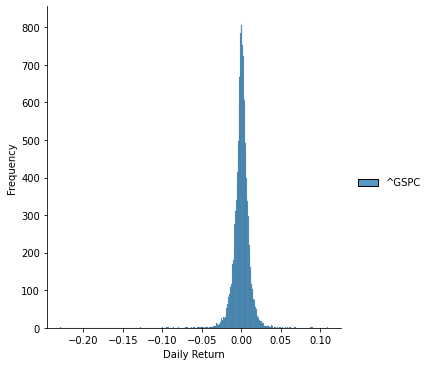

In [3]:
# compute logarithmic returns and plot
log_returns = np.log(1 + market_data.pct_change())

sns.displot(log_returns.iloc[1:])
plt.xlabel("Daily Return")
plt.ylabel("Frequency")

In [4]:
# mean, variance, drift, and stdev

u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5*var)
stdev = log_returns.std()

print(f'Mean: {u}')
print(f'Variance: {var}')
print(f'Drift: {drift}')

Mean: ^GSPC    0.00031
dtype: float64
Variance: ^GSPC    0.000098
dtype: float64
Drift: ^GSPC    0.000261
dtype: float64


In [5]:
# simulate daily returns
years = 30
avg_trading_days_yearly = 252
avg_trading_days_monthly = 21
days = avg_trading_days_yearly * years

trials = 10000

Z = norm.ppf(np.random.rand(days, trials))
daily_returns = np.exp(drift.values + stdev.values * Z)

In [6]:
# calculating index price paths for every trial
price_paths = np.zeros_like(daily_returns)
price_paths[0] = market_data.iloc[-1]
for t in range(1, days):
    price_paths[t] = price_paths[t-1]*daily_returns[t]

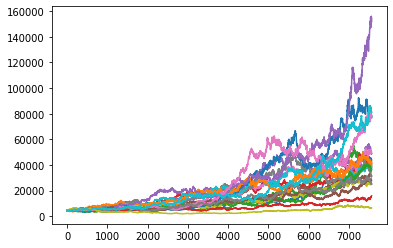

In [7]:
# plot first 20 trial price paths

for trial in range(min(20, trials)):
    plt.plot(price_paths[:7560, trial:trial+1])

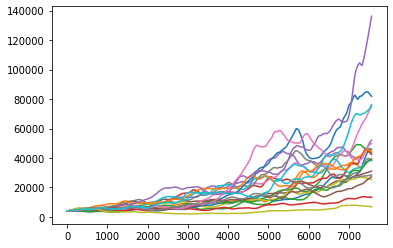

In [8]:
# calculate 10-month (~200 trading day) simple moving average for each trial
moving_average = np.zeros_like(price_paths)
above_moving_average = np.zeros_like(price_paths)

for t in range(200):
    moving_average[t] = (sum([market_data.to_numpy()[-i] for i in range(1, 200-t)]) + sum([price_paths[i] for i in range(t+1)]))/200.0

for t in range(200, days):
    moving_average[t] = sum([price_paths[i] for i in range(t-200+1,t+1)])/200.0

for t in range(days):    
    above_moving_average[t] = np.heaviside(price_paths[t] - moving_average[t], 0)

for trial in range(min(20, trials)):
    plt.plot(moving_average[:7560, trial:trial+1])

In [9]:
def simulate_portfolio_performance(price_paths, params):
    free_cash = np.zeros_like(price_paths)
    remaining_loan_principal = np.zeros_like(price_paths)
    brokerage_holdings = np.zeros_like(price_paths)
    retirement_holdings = np.zeros_like(price_paths)

    free_cash[0] = params['initial_cash'] + params['loan_amount'] - params['points_cost']
    remaining_loan_principal[0] = params['loan_amount']
    brokerage_holdings[0] = params['initial_brokerage_value']/price_paths[0]
    retirement_holdings[0] = (params['initial_retirement_value'] - params['loan_amount'])/price_paths[0]
    
    biweekly_cash_savings = params['biweekly_cash_savings']
    biweekly_loan_payment = params['biweekly_loan_payment']
    monthly_points_savings = params['monthly_points_savings']
    biweekly_retirement_contribution = params['biweekly_retirement_contribution']
    early_payoff = params['early_payoff']

    for t in range(1, days):
        # stack paper
        free_cash[t] = free_cash[t-1]
        remaining_loan_principal[t] = remaining_loan_principal[t-1]
        retirement_holdings[t] = retirement_holdings[t-1]
        brokerage_holdings[t] = brokerage_holdings[t-1]

        # payday
        payday = int((t % 29) in [0, 9, 19]) # payday indicator, either 0 or 1. there are on average 9.66 trading days per biweekly pay period, so this works nicely
        free_cash[t] += payday*biweekly_cash_savings
        free_cash[t] -= payday*np.minimum(remaining_loan_principal[t], biweekly_loan_payment)
        retirement_holdings[t] += payday*np.minimum(remaining_loan_principal[t], biweekly_loan_payment)/price_paths[t]
        retirement_holdings[t] += payday*biweekly_retirement_contribution/price_paths[t]
        remaining_loan_principal[t] -= payday*np.minimum(remaining_loan_principal[t], biweekly_loan_payment*7.0/9) # seven ninths go towards principal
    
        # mortgage savings from points
        mortgage_day = int(t % 21 == 0) # average 21 trading days per month
        free_cash[t] += mortgage_day*monthly_points_savings

        # payoff loan early if enough available cash
        if isinstance(early_payoff, (bool)) and early_payoff == True:
            payoff_precon = 1
        elif isinstance(early_payoff, (bool)) and early_payoff == False:
            payoff_precon = 0
        else:
            payoff_precon = early_payoff[t]
        early_payoff_condition = payoff_precon*np.heaviside(free_cash[t] - remaining_loan_principal[t], 0)
        free_cash[t] -= early_payoff_condition*remaining_loan_principal[t]
        retirement_holdings[t] += early_payoff_condition*remaining_loan_principal[t]/price_paths[t]
        remaining_loan_principal[t] -= early_payoff_condition*remaining_loan_principal[t]

        # contribute cash in excess of remaining_loan_principal to brokerage account
        brokerage_contrib_condition = np.heaviside(free_cash[t] - remaining_loan_principal[t], 0)
        brokerage_holdings[t] += brokerage_contrib_condition*(free_cash[t] - remaining_loan_principal[t])/price_paths[t]
        free_cash[t] -= brokerage_contrib_condition*(free_cash[t] - remaining_loan_principal[t])

    return {
            'free_cash': free_cash,
            'remaining_loan_principal': remaining_loan_principal,
            'retirement_holdings': retirement_holdings,
            'brokerage_holdings': brokerage_holdings,
           }

In [45]:
# mortgage points, no 401k loan
portfolio_A_params = {
    'initial_retirement_value': 100000.00,
    'initial_cash': 10000.00,
    'initial_brokerage_value': 1000.00,
    'loan_amount': 0.00,
    'biweekly_loan_payment': 0.00,
    'biweekly_retirement_contribution': 500.00,
    'biweekly_cash_savings': 200.00,
    'points_cost': 8000.00,
    'monthly_points_savings': 100.00,
    'early_payoff': True,
}

# no mortgage points, no 401k loan
portfolio_B_params = {
    'initial_retirement_value': 100000.00,
    'initial_cash': 10000.00,
    'initial_brokerage_value': 1000.00,
    'loan_amount': 0.00,
    'biweekly_loan_payment': 0.00,
    'biweekly_retirement_contribution': 500.00,
    'biweekly_cash_savings': 200.00,
    'points_cost': 0.00,
    'monthly_points_savings': 0.00,
    'early_payoff': True,
}

portfolio_A_outcomes = simulate_portfolio_performance(price_paths, portfolio_A_params)
portfolio_B_outcomes = simulate_portfolio_performance(price_paths, portfolio_B_params)

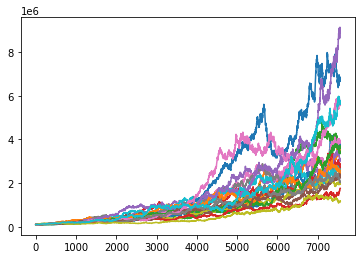

In [46]:
brokerage_value_A = portfolio_A_outcomes['brokerage_holdings']*price_paths
retirement_value_A = portfolio_A_outcomes['retirement_holdings']*price_paths
free_cash_A = portfolio_A_outcomes['free_cash']
remaining_loan_principal_A = portfolio_A_outcomes['remaining_loan_principal']

tax_adjusted_value_A = retirement_value_A + 0.8*brokerage_value_A + free_cash_A

for trial in range(min(20, trials)):
    plt.plot(tax_adjusted_value_A[:7560, trial:trial+1])

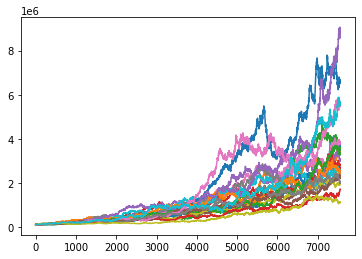

In [47]:
brokerage_value_B = portfolio_B_outcomes['brokerage_holdings']*price_paths
retirement_value_B = portfolio_B_outcomes['retirement_holdings']*price_paths
free_cash_B = portfolio_B_outcomes['free_cash']
remaining_loan_principal_B = portfolio_B_outcomes['remaining_loan_principal']

tax_adjusted_value_B = retirement_value_B + 0.8*brokerage_value_B + free_cash_B

for trial in range(min(20, trials)):
    plt.plot(tax_adjusted_value_B[:7560, trial:trial+1])

In [48]:
tax_adjusted_difference = tax_adjusted_value_A - tax_adjusted_value_B
retirement_difference = retirement_value_A - retirement_value_B
brokerage_difference = brokerage_value_A - brokerage_value_B
cash_difference = free_cash_A - free_cash_B
loan_difference = - remaining_loan_principal_A + remaining_loan_principal_B

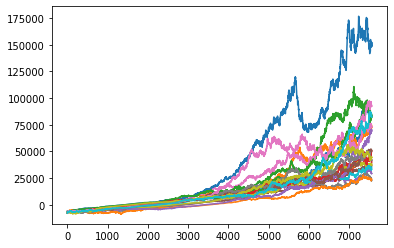

In [49]:
for trial in range(min(20, trials)):
    plt.plot(tax_adjusted_difference[:7560, trial:trial+1])

In [50]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US')

def summarize_simulation_on_trading_day(portfolio_values, t):
    df = pd.DataFrame(portfolio_values, index = [f'Trading Day {n}' for n in range(days)], columns = [f'Trial {n}' for n in range(trials)])
    df = df.loc[f'Trading Day {t}'].describe(percentiles = [0.003, 0.05, 0.32, 0.5, 0.68, 0.95, 0.997])
    df = df[['mean', 'std', 'min', '0.3%', '5%', '32%', '50%', '68%', '95%', '99.7%', 'max']].apply(lambda x: locale.currency(x, grouping=True))
    return df

def summarize_simulation_on_month(portfolio_values, N):
    return summarize_simulation_on_trading_day(portfolio_values, 21*N)

def summarize_simulation_on_year(portfolio_values, N):
    return summarize_simulation_on_trading_day(portfolio_values, 252*N)

In [51]:
summarize_simulation_on_year(tax_adjusted_difference, 3)

mean      -$4,824.50
std        $1,807.65
min      -$17,915.31
0.3%     -$11,714.35
5%        -$8,093.25
32%       -$5,419.74
50%       -$4,557.95
68%       -$3,834.39
95%       -$2,371.55
99.7%     -$1,419.11
max         -$450.08
Name: Trading Day 756, dtype: object

In [52]:
summarize_simulation_on_year(tax_adjusted_difference, 6)

mean      -$2,886.65
std        $2,673.95
min      -$25,083.81
0.3%     -$13,930.41
5%        -$7,952.94
32%       -$3,633.25
50%       -$2,344.39
68%       -$1,357.08
95%          $436.35
99.7%      $1,564.05
max        $3,027.83
Name: Trading Day 1512, dtype: object

In [53]:
summarize_simulation_on_year(tax_adjusted_difference, 9)

mean        -$419.12
std        $3,555.23
min      -$33,523.89
0.3%     -$17,087.73
5%        -$7,043.94
32%       -$1,250.26
50%          $347.99
68%        $1,538.41
95%        $3,743.04
99.7%      $5,829.98
max        $8,669.63
Name: Trading Day 2268, dtype: object

In [54]:
summarize_simulation_on_year(tax_adjusted_difference, 12)

mean       $2,700.55
std        $4,706.32
min      -$50,620.01
0.3%     -$19,134.47
5%        -$5,695.83
32%        $1,626.74
50%        $3,521.87
68%        $4,954.13
95%        $8,595.11
99.7%     $13,182.91
max       $22,522.64
Name: Trading Day 3024, dtype: object

In [55]:
summarize_simulation_on_year(tax_adjusted_difference, 15)

mean       $6,625.82
std        $6,256.22
min      -$46,699.30
0.3%     -$22,803.19
5%        -$3,993.27
32%        $4,949.05
50%        $7,088.96
68%        $9,182.18
95%       $15,461.97
99.7%     $23,984.33
max       $37,182.35
Name: Trading Day 3780, dtype: object

In [56]:
summarize_simulation_on_year(tax_adjusted_difference, 18)

mean      $11,584.39
std        $8,685.79
min      -$58,263.84
0.3%     -$26,904.66
5%        -$1,690.17
32%        $8,635.64
50%       $11,541.96
68%       $14,635.18
95%       $24,953.59
99.7%     $41,188.69
max       $75,803.95
Name: Trading Day 4536, dtype: object

In [57]:
summarize_simulation_on_year(tax_adjusted_difference, 21)

mean      $17,773.38
std       $12,091.87
min      -$92,016.25
0.3%     -$32,061.39
5%         $1,188.39
32%       $13,080.69
50%       $16,820.35
68%       $21,296.84
95%       $37,359.21
99.7%     $65,066.73
max      $124,424.39
Name: Trading Day 5292, dtype: object

In [58]:
summarize_simulation_on_year(tax_adjusted_difference, 24)

mean       $25,530.77
std        $17,179.19
min      -$137,224.95
0.3%      -$38,706.42
5%          $4,685.57
32%        $17,898.39
50%        $23,173.12
68%        $29,748.00
95%        $55,078.89
99.7%      $99,245.53
max       $194,166.05
Name: Trading Day 6048, dtype: object

In [59]:
summarize_simulation_on_year(tax_adjusted_difference, 27)

mean       $35,509.23
std        $24,533.91
min      -$235,552.37
0.3%      -$38,565.87
5%          $8,201.62
32%        $24,081.50
50%        $31,239.12
68%        $40,683.51
95%        $78,557.98
99.7%     $146,484.46
max       $406,574.99
Name: Trading Day 6804, dtype: object

In [60]:
summarize_simulation_on_month(tax_adjusted_difference, 359)

mean       $47,988.50
std        $35,012.39
min      -$327,503.57
0.3%      -$48,804.94
5%         $11,794.77
32%        $31,313.23
50%        $41,133.39
68%        $54,121.04
95%       $109,132.16
99.7%     $215,883.71
max       $777,722.21
Name: Trading Day 7539, dtype: object

In [26]:
Zi = norm.ppf(np.random.rand(days, trials))
daily_inflation = np.exp(drift.values*(-0.30) + stdev.values*0.02 * Zi)
inflation_paths = np.zeros_like(price_paths)
inflation_paths[0] = 1
for t in range(1, days):
    inflation_paths[t] = inflation_paths[t-1]*daily_inflation[t]

In [27]:
sum(inflation_paths[252])/10000.0

0.980511332376051

In [28]:
tax_inflation_adjusted_value_A = tax_adjusted_value_A*inflation_paths
tax_inflation_adjusted_value_B = tax_adjusted_value_B*inflation_paths

tax_inflation_adjusted_difference = tax_inflation_adjusted_value_A - tax_inflation_adjusted_value_B
summarize_simulation_on_month(tax_inflation_adjusted_difference, 359)

mean       $16,859.73
std        $30,294.59
min      -$173,611.35
0.3%      -$18,754.80
5%         -$4,647.24
32%         $3,184.47
50%         $8,227.11
68%        $16,056.53
95%        $65,448.71
99.7%     $218,730.66
max       $747,485.21
Name: Trading Day 7539, dtype: object

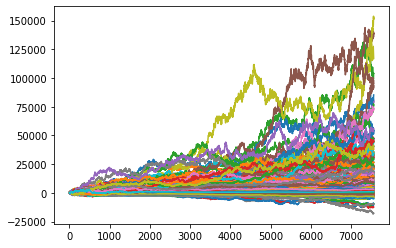

In [29]:
first_trial = 0
for trial in range(200):
    plt.plot(tax_inflation_adjusted_difference[:7560, trial+first_trial:trial+first_trial+1])

In [30]:
summarize_simulation_on_year(tax_inflation_adjusted_difference, 3)

mean      $1,958.52
std       $2,871.83
min      -$5,206.53
0.3%     -$3,494.67
5%       -$1,977.65
32%         $389.42
50%       $1,544.78
68%       $2,929.48
95%       $7,133.04
99.7%    $12,771.51
max      $22,440.89
Name: Trading Day 756, dtype: object

In [31]:
summarize_simulation_on_year(tax_inflation_adjusted_difference, 6)

mean      $3,625.46
std       $4,332.30
min      -$5,616.73
0.3%     -$3,444.31
5%       -$1,807.96
32%       $1,163.03
50%       $2,764.76
68%       $4,834.60
95%      $11,906.36
99.7%    $20,988.84
max      $38,738.46
Name: Trading Day 1512, dtype: object

In [32]:
summarize_simulation_on_year(tax_inflation_adjusted_difference, 9)

mean      $4,894.36
std       $5,787.05
min      -$7,207.82
0.3%     -$3,580.09
5%       -$1,681.43
32%       $1,551.84
50%       $3,560.30
68%       $6,050.47
95%      $15,972.93
99.7%    $32,636.14
max      $54,014.51
Name: Trading Day 2268, dtype: object

In [33]:
summarize_simulation_on_year(tax_inflation_adjusted_difference, 12)

mean      $5,876.92
std       $7,407.31
min      -$9,039.01
0.3%     -$4,593.36
5%       -$1,902.97
32%       $1,717.73
50%       $4,010.68
68%       $7,070.32
95%      $19,905.88
99.7%    $40,540.66
max      $87,202.33
Name: Trading Day 3024, dtype: object

In [34]:
summarize_simulation_on_year(tax_inflation_adjusted_difference, 15)

mean       $7,026.13
std        $9,277.91
min      -$10,718.91
0.3%      -$5,926.22
5%        -$2,150.40
32%        $1,876.42
50%        $4,464.54
68%        $8,165.70
95%       $24,614.68
99.7%     $56,483.54
max       $96,762.23
Name: Trading Day 3780, dtype: object

In [35]:
summarize_simulation_on_year(tax_inflation_adjusted_difference, 18)

mean       $8,374.41
std       $11,745.73
min      -$21,739.55
0.3%      -$8,266.20
5%        -$2,483.48
32%        $2,071.54
50%        $5,054.53
68%        $9,293.05
95%       $30,497.83
99.7%     $71,676.78
max      $140,893.96
Name: Trading Day 4536, dtype: object

In [36]:
summarize_simulation_on_year(tax_inflation_adjusted_difference, 21)

mean       $9,958.66
std       $14,757.92
min      -$34,115.41
0.3%     -$10,482.88
5%        -$2,908.14
32%        $2,354.98
50%        $5,694.45
68%       $10,549.97
95%       $37,522.00
99.7%     $93,771.18
max      $193,709.55
Name: Trading Day 5292, dtype: object

In [37]:
summarize_simulation_on_year(tax_inflation_adjusted_difference, 24)

mean      $11,833.82
std       $18,798.70
min      -$49,554.46
0.3%     -$12,515.32
5%        -$3,462.87
32%        $2,542.48
50%        $6,345.30
68%       $12,103.96
95%       $45,027.70
99.7%    $127,237.17
max      $318,273.44
Name: Trading Day 6048, dtype: object

In [38]:
summarize_simulation_on_year(tax_inflation_adjusted_difference, 27)

mean      $14,129.75
std       $24,251.16
min      -$96,756.04
0.3%     -$15,452.88
5%        -$3,945.43
32%        $2,820.95
50%        $7,248.14
68%       $13,919.65
95%       $54,240.94
99.7%    $166,405.38
max      $566,227.45
Name: Trading Day 6804, dtype: object

In [39]:
summarize_simulation_on_month(tax_inflation_adjusted_difference, 359)

mean       $16,859.73
std        $30,294.59
min      -$173,611.35
0.3%      -$18,754.80
5%         -$4,647.24
32%         $3,184.47
50%         $8,227.11
68%        $16,056.53
95%        $65,448.71
99.7%     $218,730.66
max       $747,485.21
Name: Trading Day 7539, dtype: object

In [40]:
summarize_simulation_on_month(tax_inflation_adjusted_value_A, 359)

mean      $1,791,099.66
std       $1,516,365.21
min         $105,881.99
0.3%        $258,251.28
5%          $490,268.99
32%       $1,006,856.60
50%       $1,384,980.31
68%       $1,886,174.36
95%       $4,350,600.28
99.7%    $10,704,426.23
max      $26,888,313.07
Name: Trading Day 7539, dtype: object

In [41]:
summarize_simulation_on_month(tax_inflation_adjusted_value_B, 359)

mean      $1,774,239.93
std       $1,492,697.88
min         $105,789.31
0.3%        $258,931.34
5%          $487,539.62
32%       $1,002,208.44
50%       $1,374,955.15
68%       $1,871,671.17
95%       $4,305,316.85
99.7%    $10,516,270.64
max      $26,385,655.71
Name: Trading Day 7539, dtype: object

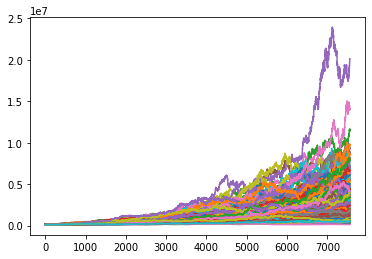

In [42]:
first_trial = 0
for trial in range(1000):
    plt.plot(tax_inflation_adjusted_value_A[:7560, trial+first_trial:trial+first_trial+1])

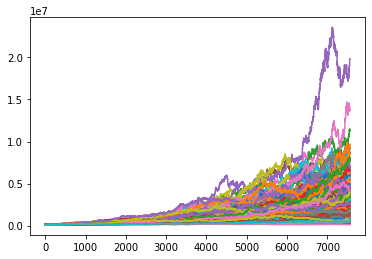

In [43]:
first_trial = 0
for trial in range(1000):
    plt.plot(tax_inflation_adjusted_value_B[:7560, trial+first_trial:trial+first_trial+1])

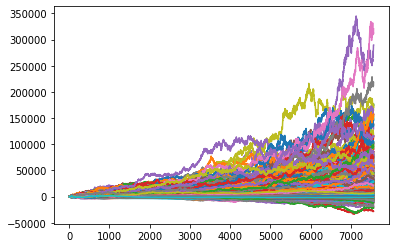

In [44]:
first_trial = 0
for trial in range(1000):
    plt.plot(tax_inflation_adjusted_difference[:7560, trial+first_trial:trial+first_trial+1])

In [61]:
summarize_simulation_on_trading_day(tax_inflation_adjusted_value_A, 0)

mean     $102,800.00
std            $0.00
min      $102,800.00
0.3%     $102,800.00
5%       $102,800.00
32%      $102,800.00
50%      $102,800.00
68%      $102,800.00
95%      $102,800.00
99.7%    $102,800.00
max      $102,800.00
Name: Trading Day 0, dtype: object

In [62]:
summarize_simulation_on_trading_day(tax_inflation_adjusted_value_A, 7559)

mean      $1,801,887.46
std       $1,538,313.61
min         $116,280.72
0.3%        $259,169.46
5%          $490,973.46
32%       $1,013,586.58
50%       $1,391,859.69
68%       $1,896,093.60
95%       $4,409,499.48
99.7%    $10,965,942.01
max      $28,219,441.07
Name: Trading Day 7559, dtype: object

In [63]:
summarize_simulation_on_trading_day(tax_adjusted_value_A, 7559)

mean      $3,258,058.12
std       $2,780,114.07
min         $210,159.79
0.3%        $470,059.71
5%          $891,202.13
32%       $1,834,515.06
50%       $2,511,584.72
68%       $3,427,864.26
95%       $7,958,126.75
99.7%    $19,909,416.73
max      $49,979,983.16
Name: Trading Day 7559, dtype: object